#  Мониторинг процесса обучения

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://mlflow.org/
* https://ngrok.com/
* https://mlflow.org/docs/latest/ml/getting-started/logging-first-model/
* https://mlflow.org/docs/latest/ml/deep-learning/pytorch/
* https://mlflow.org/docs/latest/ml/getting-started/logging-first-model/step6-logging-a-run/
* https://mlflow.org/docs/latest/ml/traditional-ml/tutorials/hyperparameter-tuning/part2-logging-plots/
* https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
* https://docs.wandb.ai/quickstart
* https://docs.wandb.ai/guides/track/log/log-summary#docusaurus_skipToContent_fallback
* https://docs.wandb.ai/guides/track/log/log-models

## Задачи для совместного разбора

In [1]:
import mlflow

In [2]:
import subprocess
from IPython.display import IFrame

port = 5000
process = subprocess.Popen(["mlflow", "ui", "--port", str(port)])
print(f"MLflow UI запущен с PID (ID процесса): {process.pid}")
# IFrame(src=f"http://localhost:{port}/", width="100%", height=700)

MLflow UI запущен с PID (ID процесса): 44808


In [3]:
mlflow.set_tracking_uri("http://localhost:5000")

1\. Рассмотрите возможности пакета `mlflow` по отслеживанию числовых значений, визуализации изображений, таблиц и других артефактов.

## Задачи для самостоятельного решения

In [4]:
# !pip install playwright
# !playwright install

In [15]:
import torch
import torch.nn as nn
import torch as th
from torch.utils.data import TensorDataset, DataLoader

import wandb

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score,
							 mean_squared_error,
							 mean_absolute_error,
							 mean_absolute_percentage_error,
							 accuracy_score,
							 precision_score,
							 recall_score,
							 f1_score,
							 confusion_matrix)
import numpy as np
import mlflow.pytorch
from IPython.display import HTML,Image, display
import time
import asyncio
from playwright.sync_api import sync_playwright
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import threading
import pandas as pd
import subprocess
import sys
import time
import os
from playwright.sync_api import sync_playwright

def run_screenshot_script(url, output_path, width=1920, height=1480):
	"""
	Делает скриншот, запуская Playwright в изолированном подпроцессе,
	чтобы избежать конфликтов asyncio, не требуя отдельного файла скрипта.
	"""
	script_code = """
import sys
import time
from playwright.sync_api import sync_playwright

def take_screenshot(url, output_path, width, height):
	'''
	Запускает браузер, переходит по URL и сохраняет скриншот.
	'''
	try:
		with sync_playwright() as p:
			browser = p.chromium.launch()
			page = browser.new_page()
			page.set_viewport_size({"width": int(width), "height": int(height)})
			page.goto(url)
			time.sleep(5)  # Даем время на прогрузку JS
			page.screenshot(path=output_path)
			browser.close()
		print(f"Picture succesfully saved in {output_path}")
	except Exception as e:
		print(f"Error occured in Playwright subprocess: {e}", file=sys.stderr)
		sys.exit(1)

if __name__ == "__main__":
	script_url = sys.argv[1]
	script_output_path = sys.argv[2]
	script_width = sys.argv[3]
	script_height = sys.argv[4]

	take_screenshot(script_url, script_output_path, script_width, script_height)
"""
	python_executable = sys.executable
	command = [
		python_executable,
		"-c",
		script_code,
		url,
		output_path,
		str(width),
		str(height)
	]

	try:
		result = subprocess.run(
			command,
			capture_output=True,
			text=True,
			check=True
		)

		if result.stdout:
			print(result.stdout.strip())

		if result.stderr:
			print("Сообщения из потока ошибок:", result.stderr.strip(), file=sys.stderr)

	except subprocess.CalledProcessError as e:
		print("Ошибка: не удалось выполнить скрипт скриншота.", file=sys.stderr)
		print(f"Код возврата: {e.returncode}", file=sys.stderr)
		print(f"Stdout:\n{e.stdout}", file=sys.stderr)
		print(f"Stderr:\n{e.stderr}", file=sys.stderr)
	except FileNotFoundError:
		print(f"Ошибка: не удалось найти '{python_executable}'. Убедитесь, что Python установлен и доступен.", file=sys.stderr)

<p class="task" id="1"></p>

1\. Решите задачу регрессии, используя для мониторинга процесса обучения `mlflow`.

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики $R^2$ по эпохам. После завершения обучения рассчитайте значение метрик MSE, RMSE, MAE и MAPE и сохраните при помощи `log_metric`. Сохраните обученную модель при помощи `mlflow.pytorch.log_model`.

Обучите не менее трех моделей (с разной архитектурой или гиперпараметрами), отследите все запуски при помощи `mlflow` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `mlflow` с графиками обучения. Для каждого запуска сохраняйте гиперпараметры модели и summary (страница overview).

- [ ] Проверено на семинаре

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlflow.set_tracking_uri("file:./mlruns")
exp = mlflow.set_experiment("Sine Wave Regression")

In [ ]:
def train_and_log_model(params):
	with mlflow.start_run() as run:
		run_id = run.info.run_id
		experiment_id = run.info.experiment_id
		dset = TensorDataset(X_train,y_train)
		loader = DataLoader(dset, batch_size=params["batch_size"], shuffle=True)

		mlflow.log_params(params)

		model = nn.Sequential(
			nn.Linear(params["input_dim"], params["hidden_dim"]),
			nn.Tanh(),
			nn.Linear(params["hidden_dim"], params["output_dim"])
		)

		criterion = nn.MSELoss()
		optimizer = torch.optim.SGD(model.parameters(), lr=params["learning_rate"])

		for epoch in tqdm(range(params["epochs"]), 'epoch'):
			epoch_loss = 0
			for X_batch, y_batch in loader:
				y_pred = model(X_batch).flatten()
				loss = criterion(y_pred, y_batch.flatten())
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
				epoch_loss+=loss.item()

			avg_epoch_loss = epoch_loss / len(loader)
			mlflow.log_metric("train_loss", avg_epoch_loss, step=epoch)

			with torch.no_grad():
				test_pred = model(X_test)
				test_loss = criterion(test_pred, y_test)
				r2 = r2_score(y_test.numpy(), test_pred.numpy())
				mlflow.log_metric("test_loss", test_loss.item(), step=epoch)
				mlflow.log_metric("r2_score", r2, step=epoch)

		with torch.no_grad():
			final_preds = model(X_test)
			mse = mean_squared_error(y_test.numpy(), final_preds.numpy())
			rmse = np.sqrt(mse)
			mae = mean_absolute_error(y_test.numpy(), final_preds.numpy())
			mape = mean_absolute_percentage_error(y_test.numpy(), final_preds.numpy())
			metrics = {
				"final_mse": mse,
				"final_rmse": rmse,
				"final_mae": mae,
				"final_mape": mape
			}
			mlflow.log_metrics(metrics)

		mlflow.pytorch.log_model(model, "model")
		mlflow.log_text(str(model), "model_summary.txt")

		run_url = f"http://localhost:{port}/#/experiments/{experiment_id}/runs/{run_id}/model-metrics"
		screenshot_path = f"images/run_{run_url.split('/')[-1]}_metrics.png"

		try:
			run_screenshot_script(run_url, screenshot_path)
			display(Image(filename=screenshot_path))
		except Exception as e:
			print(f"Failed to generate or display the screenshot: {e}")

		return run_url

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

2025/10/13 20:46:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 20:46:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/13 20:46:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/13 20:46:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter whe

Picture succesfully saved in images/run_model-metrics_metrics.png


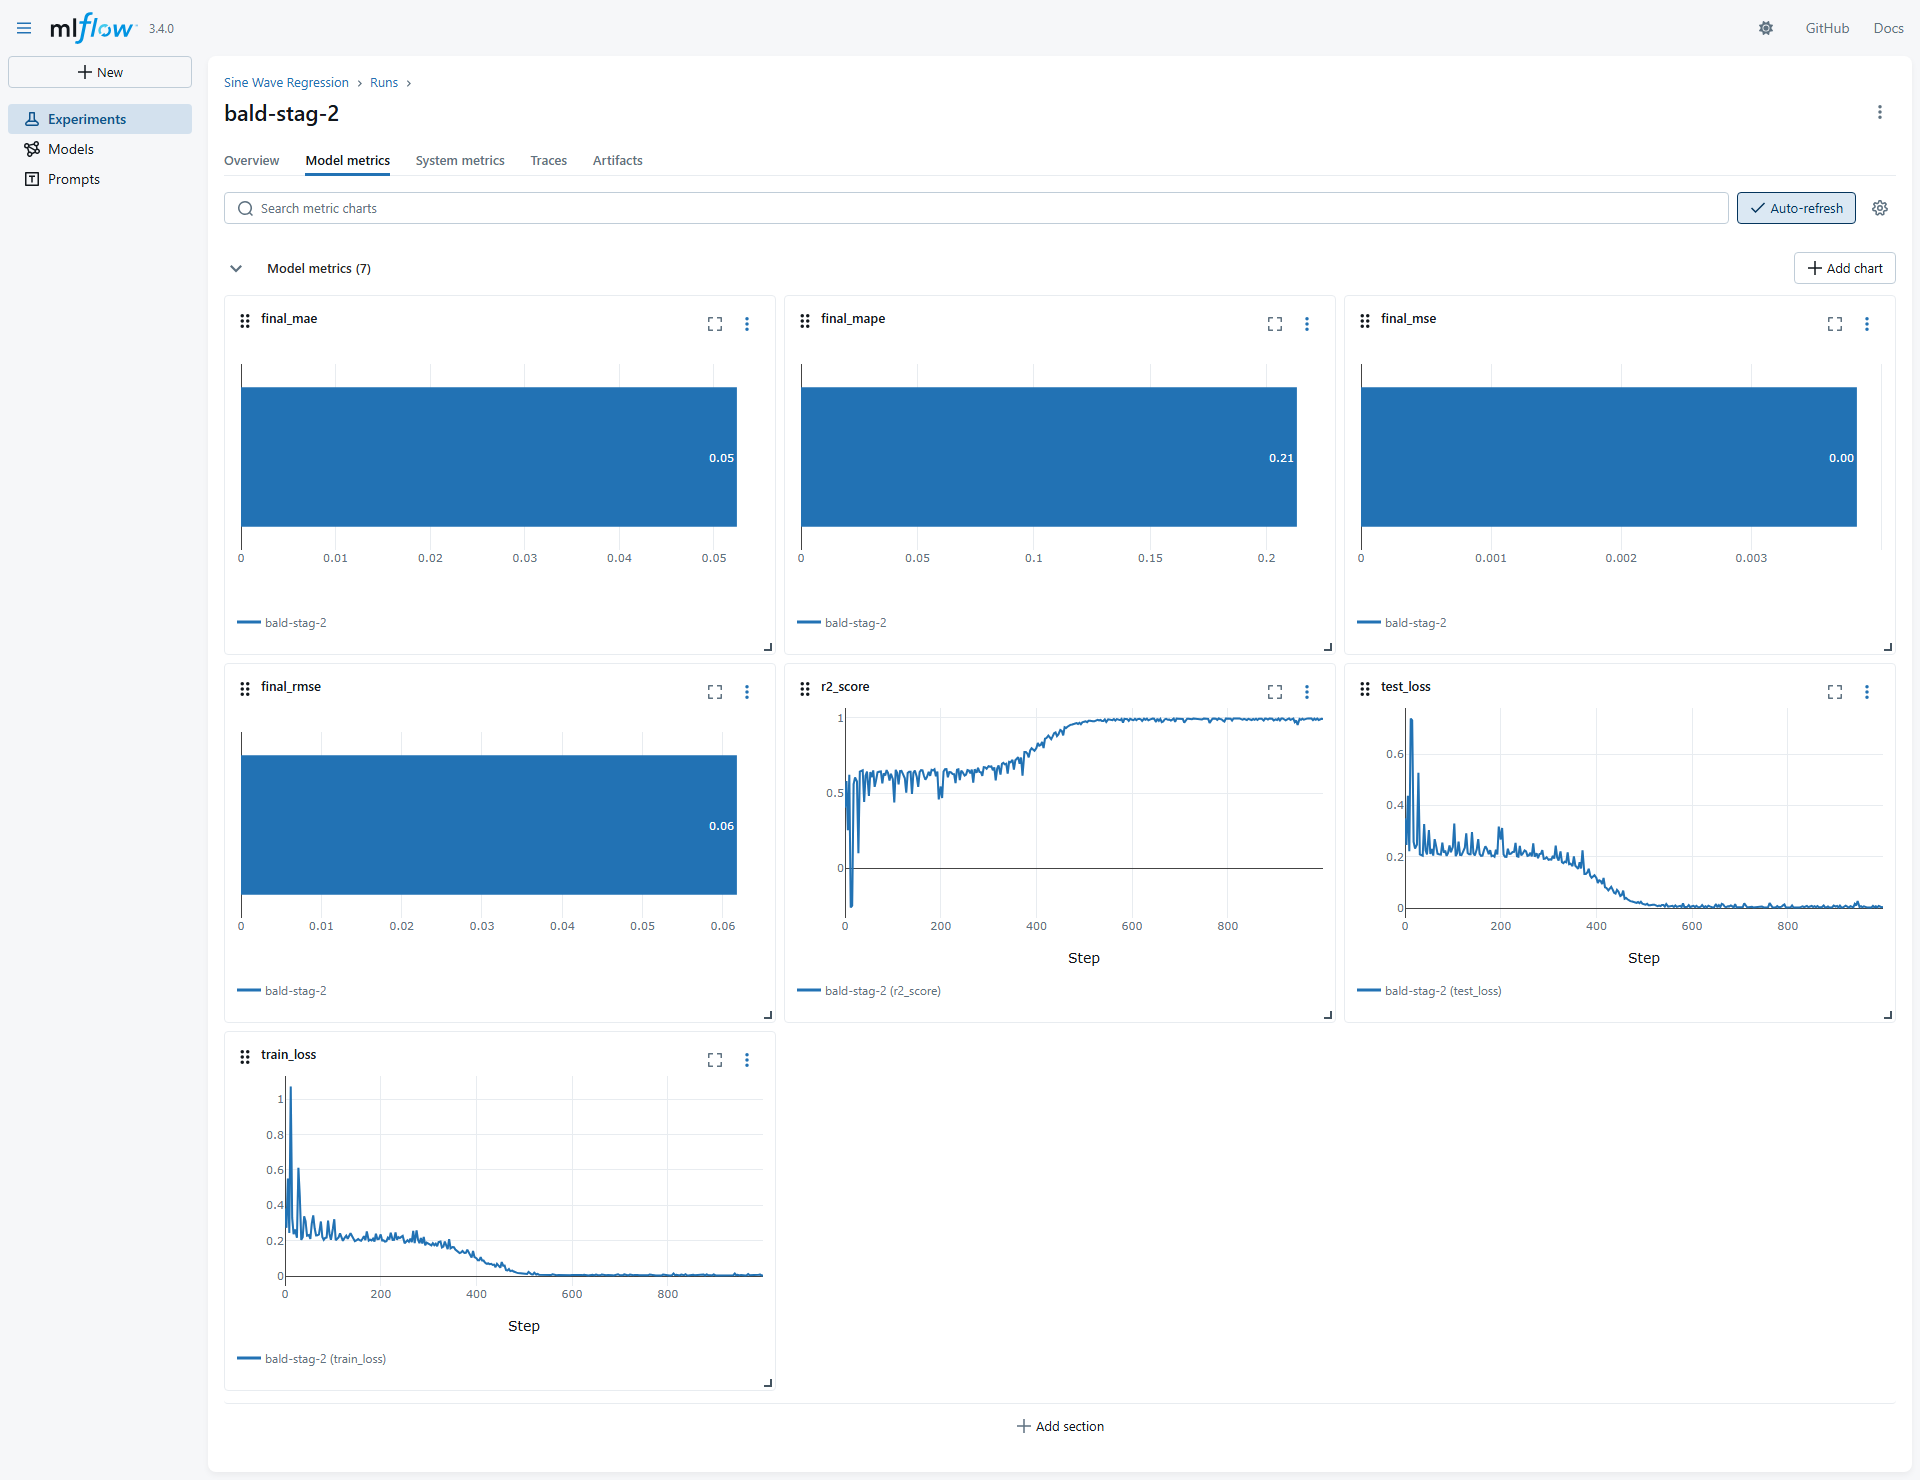

In [ ]:
params = {
	"input_dim": X.shape[1],
	"output_dim": 1,
	"hidden_dim": 50,
	"learning_rate": 0.07,
	"epochs": 1000,
	"batch_size": 16
}

run_url = train_and_log_model(params)

<p class="task" id="2"></p>

2\. Решите задачу классификации, используя для мониторинга процесса обучения `mlflow`.

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики `Accuracy` по эпохам. После завершения обучения рассчитайте значение метрик Accuracy, Precision, Recall и F1 и сохраните при помощи `log_metric`. Сохраните обученную модель при помощи `mlflow.pytorch.log_model`.

Отследите все запуски при помощи `mlflow` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `mlflow` с графиками обучения. Для каждого запуска приложите также скриншот с описанием гиперпараметров модели.


- [ ] Проверено на семинаре

In [6]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
experiment_name = "Circle Classification"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:c:/Projects/FU/Course_3/DL/mlruns/841953316734521037', creation_time=1760280358727, experiment_id='841953316734521037', last_update_time=1760280358727, lifecycle_stage='active', name='Circle Classification', tags={}>

In [ ]:
def train_and_log_classification_model(params):
	"""
	Обучает модель классификации, логирует параметры, метрики и модель в MLflow.
	"""
	with mlflow.start_run() as run:
		mlflow.log_params(params)
		run_id = run.info.run_id
		experiment_id = run.info.experiment_id

		dset = TensorDataset(X_train, y_train)
		loader = DataLoader(dset, batch_size=params["batch_size"], shuffle=True)

		# Определение модели
		model = nn.Sequential(
			nn.Linear(params["input_dim"], params["hidden_dim"]),
			nn.ReLU(),
			nn.Linear(params["hidden_dim"], params["output_dim"])
		)

		criterion = nn.CrossEntropyLoss()
		optimizer = th.optim.SGD(model.parameters(), lr=params["learning_rate"])

		# Цикл обучения
		for epoch in tqdm(range(params["epochs"]),'epoch'):
			epoch_loss = 0
			for X_batch, y_batch in loader:
				y_pred = model(X_batch)
				loss = criterion(y_pred, y_batch)
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
				epoch_loss+=loss.item()

			avg_epoch_loss = epoch_loss / len(loader)
			mlflow.log_metric("train_loss", avg_epoch_loss, step=epoch)

			with th.no_grad():
				test_logits = model(X_test)
				test_loss = criterion(test_logits, y_test).item()
				test_preds = th.argmax(th.softmax(test_logits, dim=1), dim=1)
				test_acc = accuracy_score(y_test.numpy(), test_preds.numpy())
				train_logits = model(X_train)
				train_preds = th.argmax(th.softmax(train_logits, dim=1), dim=1)
				train_acc = accuracy_score(y_train.numpy(), train_preds.numpy())

				mlflow.log_metric("test_loss", test_loss, step=epoch)
				mlflow.log_metric("test_accuracy", test_acc, step=epoch)
				mlflow.log_metric("train_accuracy", train_acc, step=epoch)

		with th.no_grad():
			final_logits = model(X_test)
			final_preds = th.argmax(th.softmax(final_logits, dim=1), dim=1)

			accuracy = accuracy_score(y_test.numpy(), final_preds.numpy())
			precision = precision_score(y_test.numpy(), final_preds.numpy(), average='binary')
			recall = recall_score(y_test.numpy(), final_preds.numpy(), average='binary')
			f1 = f1_score(y_test.numpy(), final_preds.numpy(), average='binary')

			final_metrics = {
				"final_accuracy": accuracy,
				"final_precision": precision,
				"final_recall": recall,
				"final_f1_score": f1
			}
			mlflow.log_metrics(final_metrics)

		# Логирование модели
		mlflow.pytorch.log_model(model, "model")
		mlflow.log_text(str(model), "model_summary.txt")

		run_url = f"http://localhost:{port}/#/experiments/{experiment_id}/runs/{run_id}/model-metrics"
		screenshot_path = f"images/run_{run_url.split('/')[-1]}_metrics.png"

		try:
			run_screenshot_script(run_url, screenshot_path)
			display(Image(filename=screenshot_path))
		except Exception as e:
			print(f"Failed to generate or display the screenshot: {e}")
		return run_url

epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

2025/10/13 20:53:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 20:53:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/13 20:53:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/13 20:53:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter whe

Picture succesfully saved in images/run_model-metrics_metrics.png


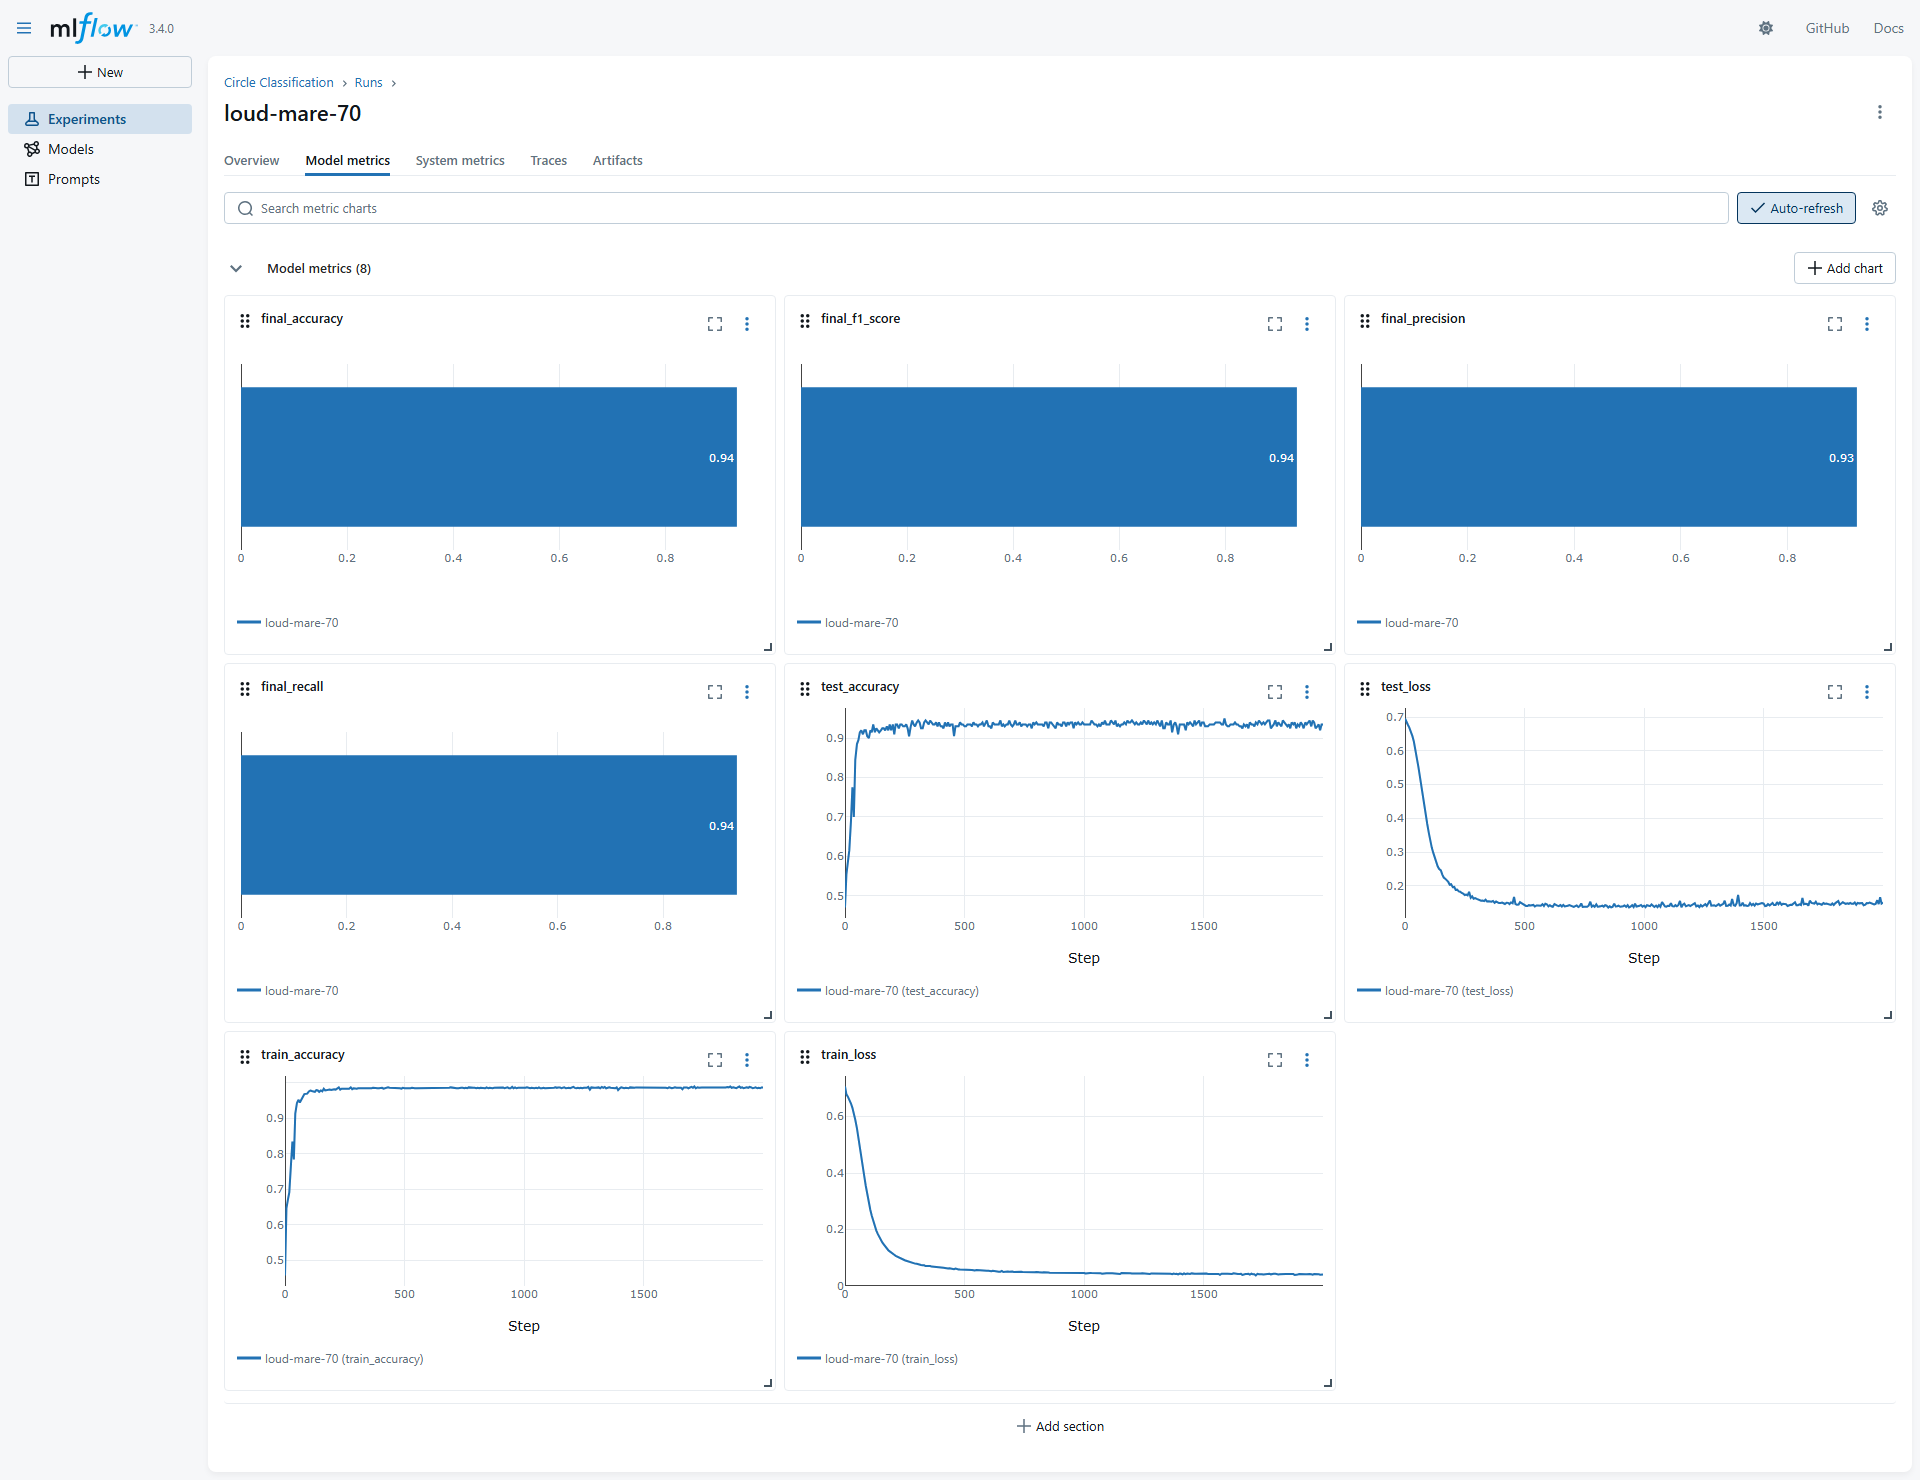

'http://localhost:5000/#/experiments/841953316734521037/runs/6273971e842b4a06a44ed708cd9036fd/model-metrics'

In [ ]:
params = {
	"input_dim": X.shape[1],
	"output_dim": 2,
	"hidden_dim": 10,
	"learning_rate": 0.028,
	"epochs": 2000,
	"batch_size": 16,
	"run_name": "Simple Model"
}
train_and_log_classification_model(params)

<p class="task" id="3"></p>

3\. Повторите задачу 2, вычислив и визуализировав матрицу несоответствий (для обучающей и тестовой выборки). Для визуализации постройте тепловую карту при помощи `seaborn`. Сохраните изображения при помощи `log_figure`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `mlflow` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

In [ ]:
def train_and_log_classification_model(params):
	"""
	Обучает модель классификации, логирует параметры, метрики и модель в MLflow.
	"""
	with mlflow.start_run() as run:
		mlflow.log_params(params)
		run_id = run.info.run_id
		experiment_id = run.info.experiment_id

		dset = TensorDataset(X_train, y_train)
		loader = DataLoader(dset, batch_size=params["batch_size"], shuffle=True)

		# Определение модели
		model = nn.Sequential(
			nn.Linear(params["input_dim"], params["hidden_dim"]),
			nn.ReLU(),
			nn.Linear(params["hidden_dim"], params["output_dim"])
		)

		criterion = nn.CrossEntropyLoss()
		optimizer = th.optim.SGD(model.parameters(), lr=params["learning_rate"])

		# Цикл обучения
		for epoch in tqdm(range(params["epochs"]),'epoch'):
			epoch_loss = 0
			for X_batch, y_batch in loader:
				y_pred = model(X_batch)
				loss = criterion(y_pred, y_batch)
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
				epoch_loss+=loss.item()

			avg_epoch_loss = epoch_loss / len(loader)
			mlflow.log_metric("train_loss", avg_epoch_loss, step=epoch)

			with th.no_grad():
				test_logits = model(X_test)
				test_loss = criterion(test_logits, y_test).item()
				test_preds = th.argmax(th.softmax(test_logits, dim=1), dim=1)
				test_acc = accuracy_score(y_test.numpy(), test_preds.numpy())
				train_logits = model(X_train)
				train_preds = th.argmax(th.softmax(train_logits, dim=1), dim=1)
				train_acc = accuracy_score(y_train.numpy(), train_preds.numpy())

				mlflow.log_metric("test_loss", test_loss, step=epoch)
				mlflow.log_metric("test_accuracy", test_acc, step=epoch)
				mlflow.log_metric("train_accuracy", train_acc, step=epoch)

		with th.no_grad():
			final_logits = model(X_test)
			final_preds = th.argmax(th.softmax(final_logits, dim=1), dim=1)

			accuracy = accuracy_score(y_test.numpy(), final_preds.numpy())
			precision = precision_score(y_test.numpy(), final_preds.numpy(), average='binary')
			recall = recall_score(y_test.numpy(), final_preds.numpy(), average='binary')
			f1 = f1_score(y_test.numpy(), final_preds.numpy(), average='binary')

			final_metrics = {
				"final_accuracy": accuracy,
				"final_precision": precision,
				"final_recall": recall,
				"final_f1_score": f1
			}
			mlflow.log_metrics(final_metrics)

		fig, ax = plt.subplots(1,1)
		sns.heatmap(confusion_matrix(y_test.numpy(), final_preds.numpy(),), annot=True)
		plt.close(fig)

		mlflow.log_figure(fig,'confusion_matrix.png')
		mlflow.pytorch.log_model(model, "model")
		mlflow.log_text(str(model), "model_summary.txt")

		run_url = f"http://localhost:{port}/#/experiments/{experiment_id}/runs/{run_id}"
		screenshot_path = f"images/run_{run_url.split('/')[-1]}_metrics.png"
		confusion_matrix_path = f"images/run_{run_url.split('/')[-1]}_confusion_matrix.png"
		try:
			run_screenshot_script(run_url+'/model-metrics', screenshot_path)
			run_screenshot_script(run_url+"/artifacts/confusion_matrix.png", confusion_matrix_path, width=1200,height=700)
			display(Image(filename=screenshot_path))
			display(Image(filename=confusion_matrix_path))

		except Exception as e:
			print(f"Failed to generate or display the screenshot: {e}")
		return run_url

epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

2025/10/13 21:00:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 21:00:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/13 21:00:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/13 21:00:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter whe

Picture succesfully saved in images/run_930b42f57355419a834cfbed0edfa5b8_metrics.png
Picture succesfully saved in images/run_930b42f57355419a834cfbed0edfa5b8_confusion_matrix.png


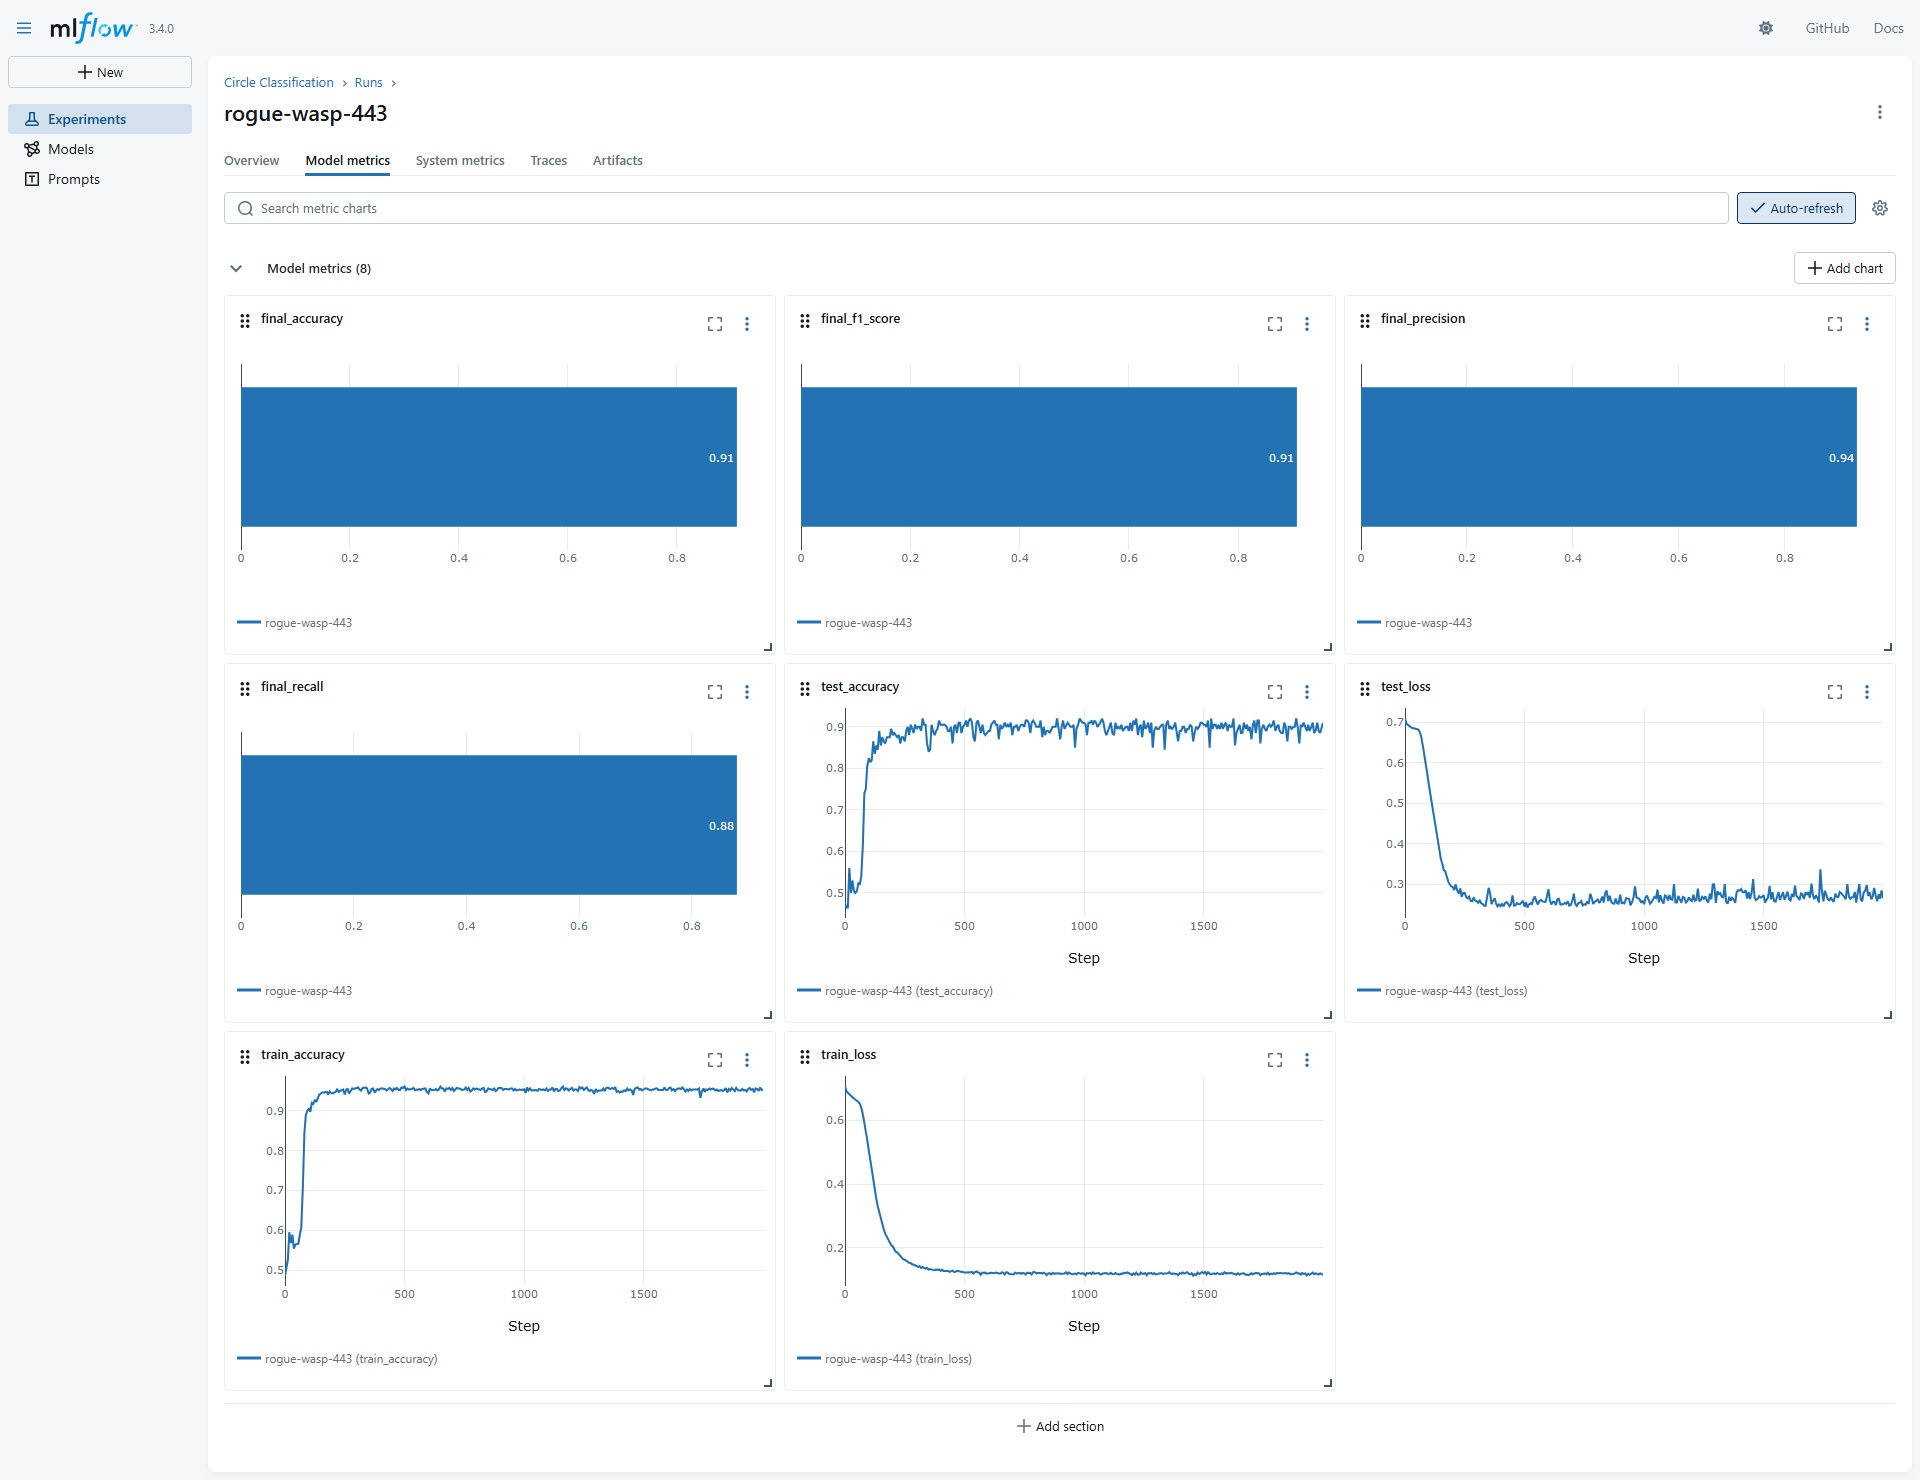

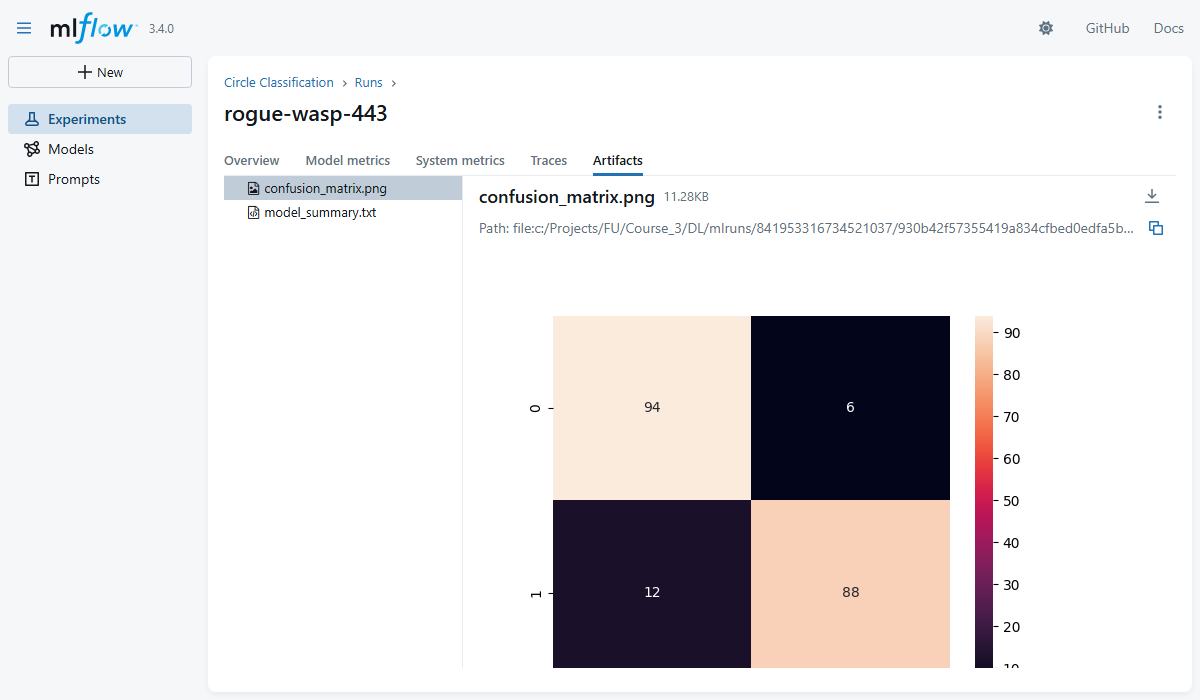

'http://localhost:5000/#/experiments/841953316734521037/runs/930b42f57355419a834cfbed0edfa5b8'

In [ ]:
params = {
	"input_dim": X.shape[1],
	"output_dim": 2,
	"hidden_dim": 10,
	"learning_rate": 0.028,
	"epochs": 2000,
	"batch_size": 16,
	"run_name": "Simple Model"
}
train_and_log_classification_model(params)

<p class="task" id="4"></p>

4\. Повторите задачу 2, обучив две модели: линейную и нелинейную. Для каждой из моделей сделайте прогноз (по всей выборке) и визуализируйте облако точек (раскрасьте точки в цвета, соответствующие прогнозам модели). Сохраните изображения при помощи `mlflow`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс в виде `wandb.Image`` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

всё, что было выше выполнялось на локальной машине, но с WANDB поработать не удалось, так что я перешел в colab.research.google.com

In [6]:
# from dotenv import load_dotenv
import os
# load_dotenv()
from google.colab import userdata

os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')

In [21]:
def train_and_log_image(config, model):
    """
    Обучает модель и логирует график matplotlib как статичное изображение в wandb.
    """
    run = wandb.init(
        project="circle-classification-task4-matplotlib",
        config=config,
        name=config["run_name"]
    )
    dset = TensorDataset(X_train, y_train)
    loader = DataLoader(dset, batch_size=config["batch_size"], shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])

    for epoch in tqdm(range(config["epochs"]), desc=f'Training {config["run_name"]}'):
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        preds = torch.argmax(model(X), dim=1).numpy()

        plt.figure(figsize=(8, 6))
        plt.scatter(X[:, 0], X[:, 1], c=preds, cmap=plt.cm.RdYlBu)
        plt.title(f'Predictions - {config["run_name"]}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        wandb.log({"predictions_plot": wandb.Image(plt)})

        plt.close()

    run.finish()
    print(f"Запуск '{config['run_name']}' в wandb успешно завершен.")

config_linear = {
    "architecture": "Linear", "learning_rate": 0.1, "epochs": 1000,
    "batch_size": 32, "run_name": "Linear Model"
}
linear_model = nn.Sequential(nn.Linear(2, 2))
train_and_log_image(config_linear, linear_model)

config_nonlinear = {
    "architecture": "Non-Linear", "learning_rate": 0.1, "epochs": 1000,
    "batch_size": 32, "hidden_dim": 10, "run_name": "Non-Linear Model"
}
nonlinear_model = nn.Sequential(
    nn.Linear(2, 10), nn.ReLU(), nn.Linear(10, 2)
)
train_and_log_image(config_nonlinear, nonlinear_model)

Training Linear Model:   0%|          | 0/1000 [00:00<?, ?it/s]

Запуск 'Linear Model' в wandb успешно завершен.


Training Non-Linear Model:   0%|          | 0/1000 [00:00<?, ?it/s]

Запуск 'Non-Linear Model' в wandb успешно завершен.


Вот такие получились графики

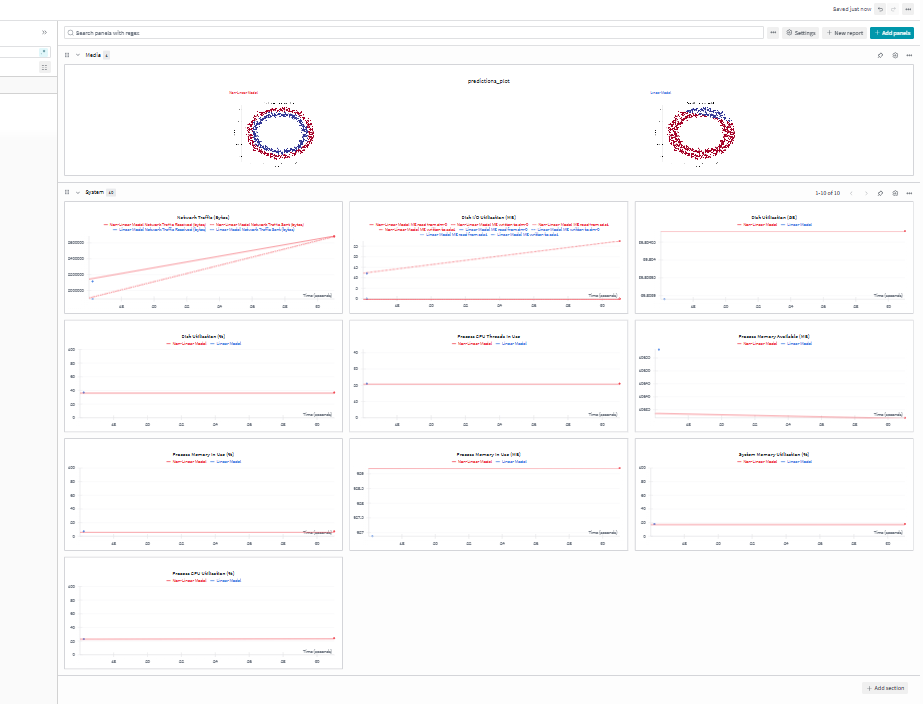

<p class="task" id="5"></p>

5\. Повторите задачу 2, реализовав логику ранней остановки. Для этого разделите данные на три части: обучающую, валидационную и тестовую. Остановите процесс обучения, если целевая метрика (F1) на валидации не увеличивалась в течении последних $k$ ($k$ - гиперпараметр метода) эпох. В момент остановки выведите сообщение с текущим номером эпохи. Сохраните для запуска номер эпохи, на которой процесс обучения был прерван.

Помимо отслеживания метрик на обучающей и тестовой выборке, также отслеживайте метрики на валидационной выборке в процессе обучения.

Постройте таблицу , в которой содержится информация о:
* признаках объекта;
* правильном ответе;
* прогнозе модели;
* принадлежности к обучающему, валидационному или тестовому множеству.

Сохраните данную таблицу при помощи `log_table`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `mlflow` со всеми нужными визуализациями.

- [ ] Проверено на семинаре


In [10]:
X, y = make_circles(n_samples=1000, noise=0.1, random_state=42, factor=0.5)
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

In [11]:
class EarlyStopping:
    """Останавливает процесс обучения, если f1 не улучшается"""
    def __init__(self, patience=10, verbose=False, delta=1e-3, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1_max = -np.inf
        self.delta = delta
        self.path = path
        self.best_epoch = 0

    def __call__(self, val_f1, model, epoch):
        score = val_f1

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1, model)
            self.best_epoch = epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1, model)
            self.counter = 0
            self.best_epoch = epoch

    def save_checkpoint(self, val_f1, model):
        """Saves model when validation F1-score increases."""
        if self.verbose:
            print(f'Validation F1 increased ({self.val_f1_max:.6f} --> {val_f1:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_f1_max = val_f1

MLflow Run Started: bedecked-crow-883


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Validation F1 increased (-inf --> 0.688172). Saving model ...
Validation F1 increased (0.688172 --> 0.764398). Saving model ...
Validation F1 increased (0.764398 --> 0.875000). Saving model ...
Validation F1 increased (0.875000 --> 0.911628). Saving model ...
Validation F1 increased (0.911628 --> 0.965174). Saving model ...
Validation F1 increased (0.965174 --> 0.980000). Saving model ...
Validation F1 increased (0.980000 --> 0.990000). Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation F1 increased (0.990000 --> 0.994975). Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation F1 increased (0.994975 --> 1.000000). Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 

2025/10/13 23:35:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


EarlyStopping counter: 24 out of 25
EarlyStopping counter: 25 out of 25
Early stopping triggered at epoch 40.
Loaded best model from epoch 15 with validation F1: 1.0000


2025/10/13 23:35:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/13 23:36:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/13 23:36:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged prediction results table to MLflow.
Picture succesfully saved in images/run_d749054890f741c88c6489a11a3b7a88_metrics.png
Picture succesfully saved in images/run_d749054890f741c88c6489a11a3b7a88_prediction_results.png


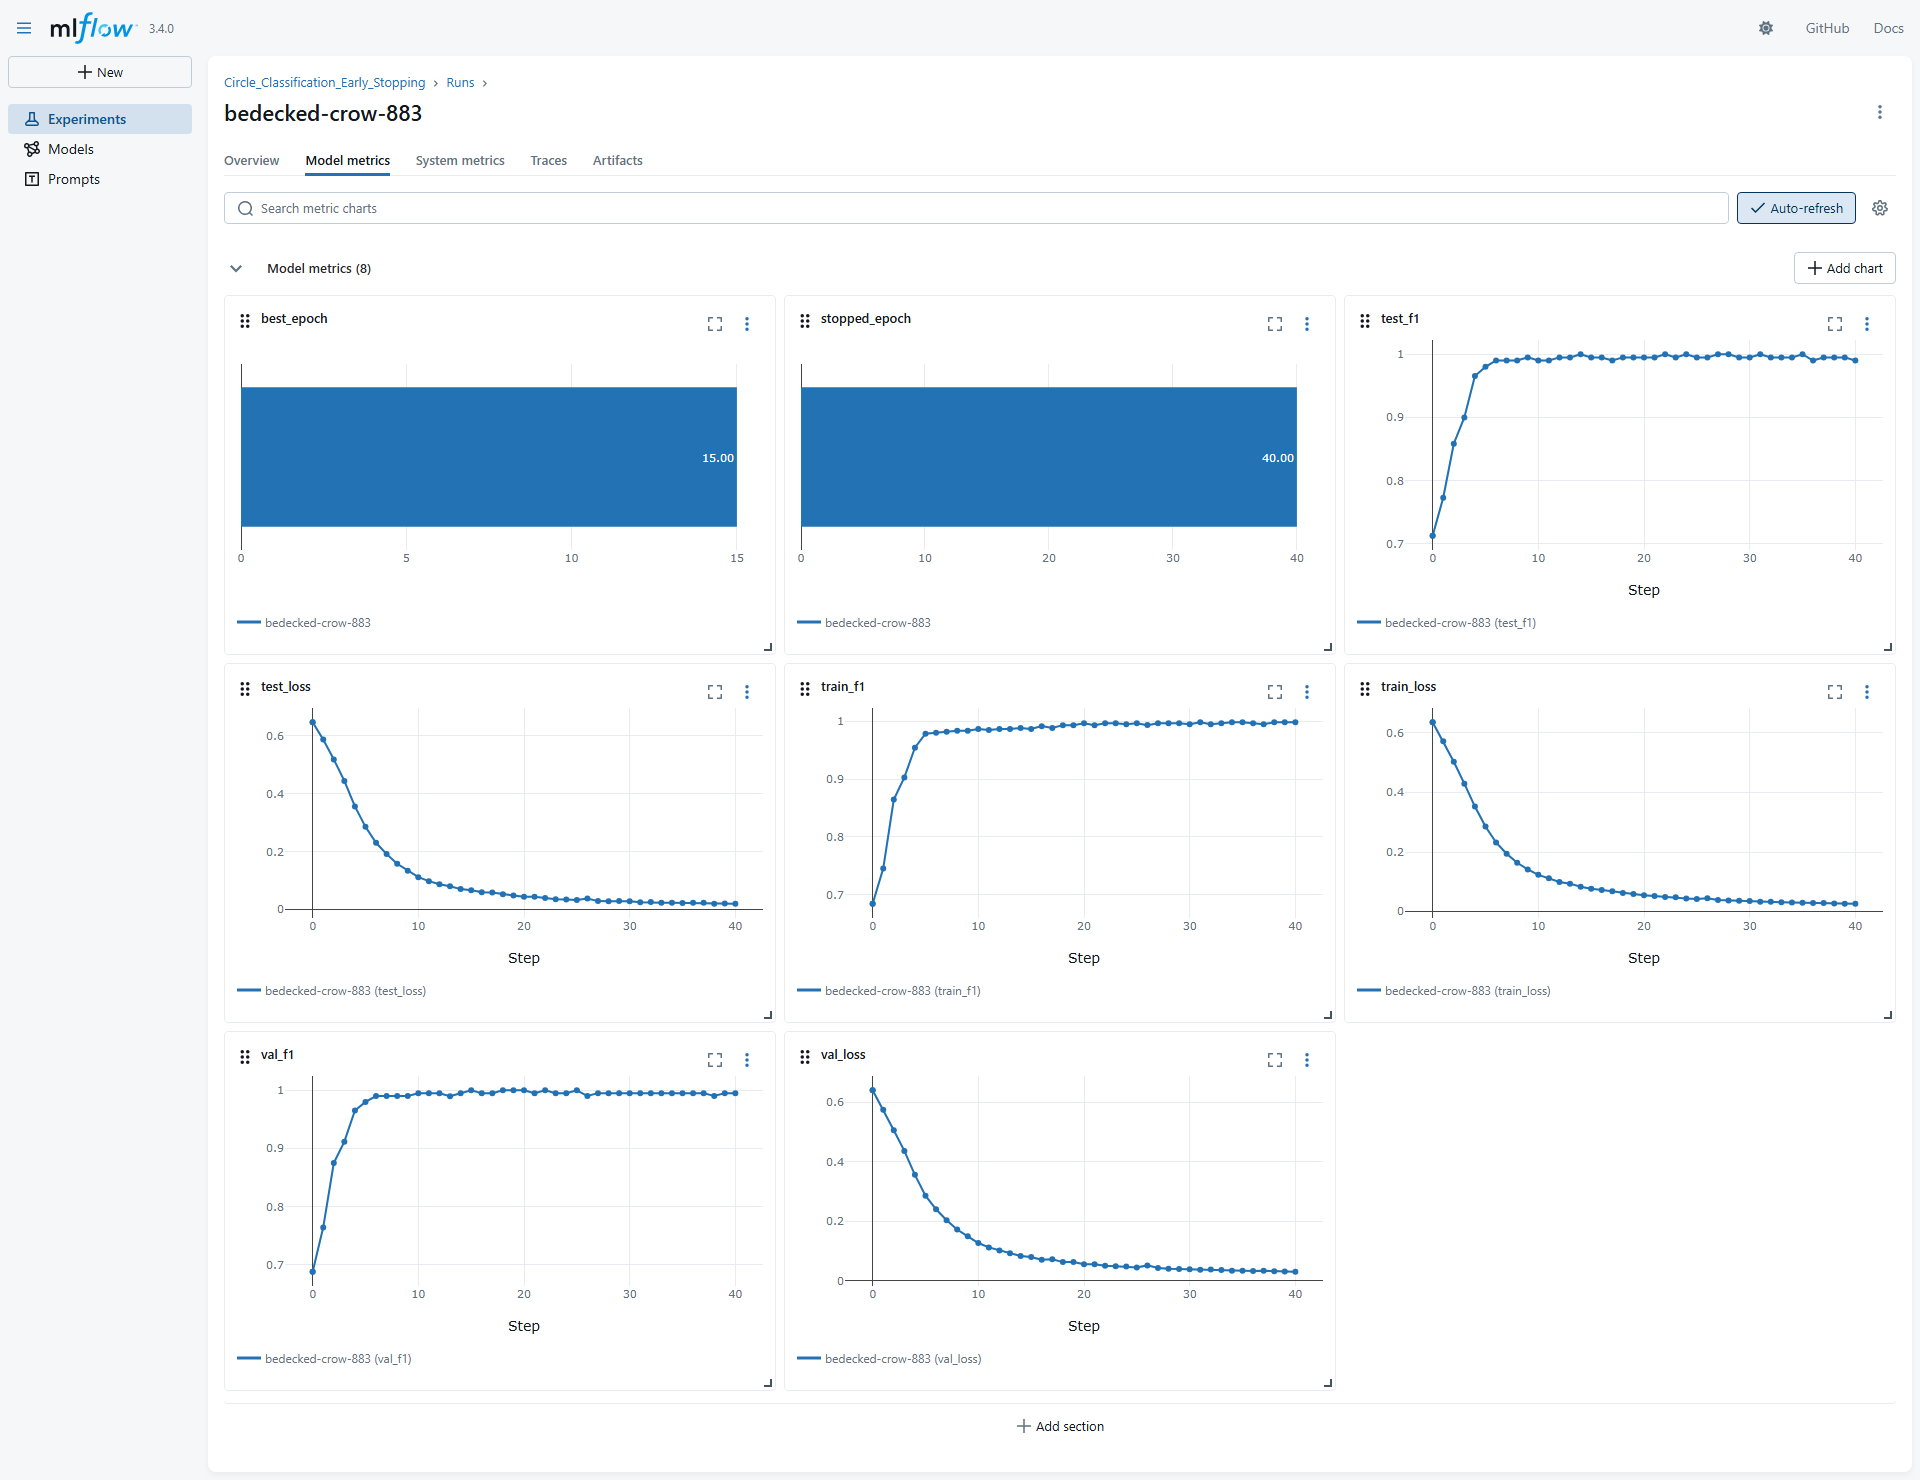

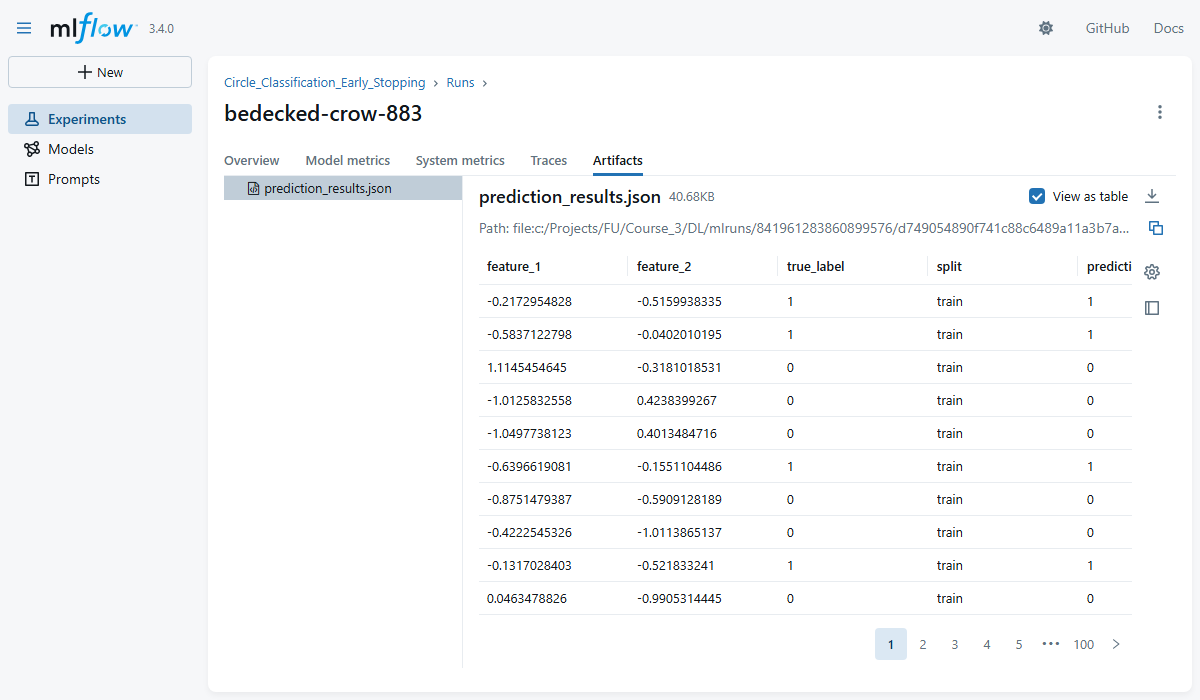

http://localhost:5000/#/experiments/841961283860899576/runs/d749054890f741c88c6489a11a3b7a88


,feature_1,feature_2,true_label,split,prediction
0,-0.217295,-0.515994,1,train,1
1,-0.583712,-0.040201,1,train,1
2,1.114545,-0.318102,0,train,0
3,-1.012583,0.423840,0,train,0
4,-1.049774,0.401348,0,train,0
...,...,...,...,...,...
995,0.310831,0.332461,1,test,1
996,-0.009504,-0.475827,1,test,1
997,0.383505,-0.710279,0,test,1
998,-0.250163,0.401791,1,test,1


In [22]:
def train_and_log_with_early_stopping(params):
    mlflow.set_tracking_uri("file:./mlruns")
    mlflow.set_experiment("Circle_Classification_Early_Stopping")

    with mlflow.start_run() as run:
        run_id = run.info.run_id
        experiment_id = run.info.experiment_id
  
        print(f"MLflow Run Started: {run.info.run_name}")
        mlflow.log_params(params)

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)

        model = nn.Sequential(
            nn.Linear(params["input_dim"], params["hidden_dim"]),
            nn.ReLU(),
            nn.Linear(params["hidden_dim"], params["output_dim"])
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])

        early_stopper = EarlyStopping(patience=params["patience"], verbose=True)
        
        stopped_epoch = params["epochs"]

        for epoch in tqdm(range(params["epochs"]), 'Epochs'):
            model.train()
            for X_batch, y_batch in train_loader:
                y_pred_logits = model(X_batch)
                loss = criterion(y_pred_logits, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                # Train metrics
                train_logits = model(X_train)
                train_loss = criterion(train_logits, y_train).item()
                train_preds = torch.argmax(train_logits, dim=1)
                train_f1 = f1_score(y_train.numpy(), train_preds.numpy())

                # Validation metrics
                val_logits = model(X_val)
                val_loss = criterion(val_logits, y_val).item()
                val_preds = torch.argmax(val_logits, dim=1)
                val_f1 = f1_score(y_val.numpy(), val_preds.numpy())

                # Test metrics
                test_logits = model(X_test)
                test_loss = criterion(test_logits, y_test).item()
                test_preds = torch.argmax(test_logits, dim=1)
                test_f1 = f1_score(y_test.numpy(), test_preds.numpy())

            metrics_log = {
                "train_loss": train_loss, "train_f1": train_f1,
                "val_loss": val_loss, "val_f1": val_f1,
                "test_loss": test_loss, "test_f1": test_f1
            }
            mlflow.log_metrics(metrics_log, step=epoch)

            early_stopper(val_f1, model, epoch)
            if early_stopper.early_stop:
                stopped_epoch = epoch
                print(f"Early stopping triggered at epoch {epoch}.")
                break
        
        mlflow.log_metric("stopped_epoch", stopped_epoch)

        model.load_state_dict(torch.load(early_stopper.path))
        print(f"Loaded best model from epoch {early_stopper.best_epoch} with validation F1: {early_stopper.best_score:.4f}")
        mlflow.log_metric("best_epoch", early_stopper.best_epoch)
        mlflow.pytorch.log_model(model, "best_model")

        df_train = pd.DataFrame(X_train.numpy(), columns=['feature_1', 'feature_2'])
        df_train['true_label'] = y_train.numpy()
        df_train['split'] = 'train'

        df_val = pd.DataFrame(X_val.numpy(), columns=['feature_1', 'feature_2'])
        df_val['true_label'] = y_val.numpy()
        df_val['split'] = 'validation'

        df_test = pd.DataFrame(X_test.numpy(), columns=['feature_1', 'feature_2'])
        df_test['true_label'] = y_test.numpy()
        df_test['split'] = 'test'
        
        results_df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

        full_X_tensor = torch.FloatTensor(results_df[['feature_1', 'feature_2']].values)
        with torch.no_grad():
            predictions = torch.argmax(model(full_X_tensor), dim=1).numpy()
        
        results_df['prediction'] = predictions
        
        mlflow.log_table(data=results_df, artifact_file="prediction_results.json")
        print("Logged prediction results table to MLflow.")

        if os.path.exists(early_stopper.path):
            os.remove(early_stopper.path)
            
        run_url = f"http://localhost:{port}/#/experiments/{experiment_id}/runs/{run_id}"
        screenshot_path = f"images/run_{run_url.split('/')[-1]}_metrics.png"
        prediction_results = f"images/run_{run_url.split('/')[-1]}_prediction_results.png"
        try:
            run_screenshot_script(run_url+'/model-metrics', screenshot_path)
            run_screenshot_script(run_url+"/artifacts/prediction_results.json", prediction_results, width=1200,height=700)
            display(Image(filename=screenshot_path))
            display(Image(filename=prediction_results))
        except Exception as e:
            print(f"Failed to generate or display the screenshot: {e}")
        return run_url, results_df
            


params = {
    "input_dim": X.shape[1],
    "output_dim": 2,
    "hidden_dim": 16,
    "learning_rate": 0.01,
    "epochs": 500,
    "batch_size": 32,
    "patience": 25,
    "run_name": "Classification_with_Early_Stopping"
}

run_url, results_df = train_and_log_with_early_stopping(params)
print(run_url)
display(results_df)